# Step 0: Imports
Read in our 3 favorite libraries here, plus any more you might need.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timezone
import pytz

# Step 1: Load in Data
Read in `mission_data.csv`, a dataset containing the details of cleaning missions for a sample of 10,000 wifi-connected robots. The columns are defined as follows:

* `robotid`: a unique robot identifier
* `datetime`: a date string that represents the start time of a mission in GMT
* `nmssn`: mission number. This information comes from an internal counter on the robot that increments +1 per mission. Be aware that the complete mission history from mission 1 may not be included for each robot (due to missions being run before the robot was connected to wifi or data loss). The max mission number per robot should reflect its total number of missions to date reported to the database.
* `runm`: this is the time in minutes that the robot spent actually cleaning.
* `chrgm`: this is the time in minutes that a robot spent charging.
* `pausem`: this is the time in minutes that a robot spent paused.
* `outcome`: this is the end status of a mission. "Cncl" indicates that the mission was cancelled by the user. "Stuck" means the robot got stuck on an obstacle, and was not rescued within 90 minutes, so could not return to the dock. "Bat" means the robot's battery grew too low for it to return to the dock. "Ok" means the robot successfully completed cleaning the space and returned to the dock.

Read in `geo_data.csv`, a dataset containing the details of the robot's geographic location. The columns are defined as follows:

* `robotid`: unique robot identifier
* `country_cd`: 2-letter ISO country code
* `timezone`: robot's timezone (from IANA/Olson database)



In [2]:
# Loading in country codes csv for English short name
# Downloaded from github https://gist.github.com/radcliff/f09c0f88344a7fcef373
iso_codes = pd.read_csv('data/wikipedia-iso-country-codes.csv', keep_default_na=False)

In [3]:
# Look at the iso codes dataframe
iso_codes.head()

,English short name lower case,Alpha-2 code,Alpha-3 code,Numeric code,ISO 3166-2
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX
2,Albania,AL,ALB,8,ISO 3166-2:AL
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ
4,American Samoa,AS,ASM,16,ISO 3166-2:AS


In [4]:
# rename columns to make working with this df easier
iso_codes.columns = ['country', 'country_cd', 'alpha_3', 'numeric_code', 'iso_3166_2']
iso_codes.head()

,country,country_cd,alpha_3,numeric_code,iso_3166_2
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX
2,Albania,AL,ALB,8,ISO 3166-2:AL
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ
4,American Samoa,AS,ASM,16,ISO 3166-2:AS


In [5]:
mission = pd.read_csv('/Users/whuard/Desktop/General_Assembly/DS-interview-challenge/data/mission_data.csv')
mission.head()

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome
0,000NG2FMLJBT9ANZ,2017-10-01 16:17:22,40,3,1,2,stuck
1,000NG2FMLJBT9ANZ,2017-10-03 14:25:56,41,83,0,13,ok
2,000NG2FMLJBT9ANZ,2017-10-04 12:32:51,42,66,13,12,ok
3,000NG2FMLJBT9ANZ,2017-10-26 02:12:55,45,72,24,0,cncl
4,000NG2FMLJBT9ANZ,2017-10-27 07:17:39,46,61,9,0,cncl


In [6]:
mission.shape

(367679, 7)

In [7]:
geo = pd.read_csv('/Users/whuard/Desktop/General_Assembly/DS-interview-challenge/data/geo_data.csv')
geo.head()

,country_cd,timezone,robotid
0,SE,Europe/Stockholm,T29NF13ZIYISNF79
1,JP,Asia/Tokyo,9S12V26O6G426OYR
2,IL,Asia/Jerusalem,QI6X3P9JKNILKKU1
3,IL,Asia/Jerusalem,7OMKNWMWA4XWC911
4,IL,Asia/Jerusalem,YO63CL0ZFK83SYCZ


In [8]:
geo.shape

(10000, 3)

## Data Cleaning and Merging

In [9]:
# There are no missing values in the mission dataset
mission.isna().sum()

robotid     0
datetime    0
nmssn       0
runm        0
chrgm       0
pausem      0
outcome     0
dtype: int64

In [10]:
# There are two missing values for country_cd in 10,000 entries
geo.isna().sum()

country_cd    2
timezone      0
robotid       0
dtype: int64

In [11]:
# This will return all rows with NaN in the column specified
# As we can see we are missing the country_cd related to timezone Europe/Vaduz and Africa/Winhoek
geo[geo['country_cd'].isna()]

,country_cd,timezone,robotid
6091,NaN,Europe/Vaduz,QMJXZLREE88GULA1
6363,NaN,Africa/Windhoek,Z9JJM7JRIGJYLER2


In [12]:
# This is to show all rows with NaN in an entire frame regardless of column
geo[geo.isnull().any(axis=1)]

,country_cd,timezone,robotid
6091,NaN,Europe/Vaduz,QMJXZLREE88GULA1
6363,NaN,Africa/Windhoek,Z9JJM7JRIGJYLER2


In [13]:
# Filter the geo dataframe by timezone to see if there are any other entries for Europe/Vaduz
geo[geo['timezone']=='Europe/Vaduz']

,country_cd,timezone,robotid
6091,NaN,Europe/Vaduz,QMJXZLREE88GULA1
9657,NO,Europe/Vaduz,JCU2B100T9CTZT7L


In [14]:
# Since we know NO is the correct country_cod, we index the geo dataframe
# for null values of country_cd and where timezone is Europe/Vaduz and set the empyty value
# to equal 'NO', which is the correct country code
geo.loc[(geo['country_cd'].isna()) & (geo['timezone']=='Europe/Vaduz'),'country_cd']='NO'

In [15]:
# Filter the geo dataframe by the below timezone to ensure the country_cd strings are correct
geo[geo['timezone']=='Europe/Vaduz']

,country_cd,timezone,robotid
6091,NO,Europe/Vaduz,QMJXZLREE88GULA1
9657,NO,Europe/Vaduz,JCU2B100T9CTZT7L


In [16]:
# Now we filter the geo dataframe to see how many entries there are for 'Africa/Windhoek'
geo[geo['timezone']=='Africa/Windhoek']

,country_cd,timezone,robotid
6363,NaN,Africa/Windhoek,Z9JJM7JRIGJYLER2


In [17]:
# Seeing as there is only one entry, I used google to find the correct 2-letter ISO country_cd which is NA
# https://www.nationsonline.org/oneworld/namibia.htm
# So we use the same logic above to insert NA in the correct row
geo.loc[(geo['country_cd'].isna()) & (geo['timezone']=='Africa/Windhoek'),'country_cd']='NA'

In [18]:
# Filter by county_cd == NA to ensure the string was properly updated
geo[geo.country_cd=='NA']

,country_cd,timezone,robotid
6363,NA,Africa/Windhoek,Z9JJM7JRIGJYLER2


In [19]:
# Run one last check to ensure we have no missing values
geo.isnull().sum()

country_cd    0
timezone      0
robotid       0
dtype: int64

In [20]:
# Reminding myself of what both dataframes look like in order to merge them together in one
mission.head()

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome
0,000NG2FMLJBT9ANZ,2017-10-01 16:17:22,40,3,1,2,stuck
1,000NG2FMLJBT9ANZ,2017-10-03 14:25:56,41,83,0,13,ok
2,000NG2FMLJBT9ANZ,2017-10-04 12:32:51,42,66,13,12,ok
3,000NG2FMLJBT9ANZ,2017-10-26 02:12:55,45,72,24,0,cncl
4,000NG2FMLJBT9ANZ,2017-10-27 07:17:39,46,61,9,0,cncl


In [21]:
geo.head()

,country_cd,timezone,robotid
0,SE,Europe/Stockholm,T29NF13ZIYISNF79
1,JP,Asia/Tokyo,9S12V26O6G426OYR
2,IL,Asia/Jerusalem,QI6X3P9JKNILKKU1
3,IL,Asia/Jerusalem,7OMKNWMWA4XWC911
4,IL,Asia/Jerusalem,YO63CL0ZFK83SYCZ


In [22]:
# Look at some high level dataframe information prior to merging
mission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367679 entries, 0 to 367678
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   robotid   367679 non-null  object
 1   datetime  367679 non-null  object
 2   nmssn     367679 non-null  int64 
 3   runm      367679 non-null  int64 
 4   chrgm     367679 non-null  int64 
 5   pausem    367679 non-null  int64 
 6   outcome   367679 non-null  object
dtypes: int64(4), object(3)
memory usage: 19.6+ MB


In [23]:
# Look at some high level dataframe information prior to merging
geo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   country_cd  10000 non-null  object
 1   timezone    10000 non-null  object
 2   robotid     10000 non-null  object
dtypes: object(3)
memory usage: 234.5+ KB


In [24]:
# Converting the datime column from a string to a datetime
mission['datetime'] = pd.to_datetime(mission['datetime'])

In [25]:
# Confirming the datime column has the proper Dtype
mission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367679 entries, 0 to 367678
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   robotid   367679 non-null  object        
 1   datetime  367679 non-null  datetime64[ns]
 2   nmssn     367679 non-null  int64         
 3   runm      367679 non-null  int64         
 4   chrgm     367679 non-null  int64         
 5   pausem    367679 non-null  int64         
 6   outcome   367679 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 19.6+ MB


In [26]:
mission.head()

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome
0,000NG2FMLJBT9ANZ,2017-10-01 16:17:22,40,3,1,2,stuck
1,000NG2FMLJBT9ANZ,2017-10-03 14:25:56,41,83,0,13,ok
2,000NG2FMLJBT9ANZ,2017-10-04 12:32:51,42,66,13,12,ok
3,000NG2FMLJBT9ANZ,2017-10-26 02:12:55,45,72,24,0,cncl
4,000NG2FMLJBT9ANZ,2017-10-27 07:17:39,46,61,9,0,cncl


In [27]:
# Now I merge the two dataframes, I want to keep all records from the mission dataset,
# so I will use a left join. Both dataframes have a robotid and I will merge using that column
mis_geo = pd.merge(
    mission,
    geo,
    left_on='robotid',
    right_on='robotid',
    how='left'
)
# Using a left join, I will be able to see if we have mission data on robots but, missing location data
mis_geo.head(10)

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome,country_cd,timezone
0,000NG2FMLJBT9ANZ,2017-10-01 16:17:22,40,3,1,2,stuck,IL,Asia/Jerusalem
1,000NG2FMLJBT9ANZ,2017-10-03 14:25:56,41,83,0,13,ok,IL,Asia/Jerusalem
2,000NG2FMLJBT9ANZ,2017-10-04 12:32:51,42,66,13,12,ok,IL,Asia/Jerusalem
3,000NG2FMLJBT9ANZ,2017-10-26 02:12:55,45,72,24,0,cncl,IL,Asia/Jerusalem
4,000NG2FMLJBT9ANZ,2017-10-27 07:17:39,46,61,9,0,cncl,IL,Asia/Jerusalem
5,000Y9NBMJ77LQ7S7,2016-11-28 05:41:25,55,61,0,13,ok,JP,Asia/Tokyo
6,000Y9NBMJ77LQ7S7,2016-12-20 10:06:42,56,31,0,6,cncl,JP,Asia/Tokyo
7,000Y9NBMJ77LQ7S7,2017-02-18 03:16:40,57,11,0,2,cncl,JP,Asia/Tokyo
8,000Y9NBMJ77LQ7S7,2017-03-08 10:49:36,58,78,0,0,ok,JP,Asia/Tokyo
9,000Y9NBMJ77LQ7S7,2017-03-19 10:21:15,59,99,0,0,cncl,JP,Asia/Tokyo


In [28]:
# Confirming we are not missing any data in the merged dataframe
mis_geo.isna().sum()

robotid       0
datetime      0
nmssn         0
runm          0
chrgm         0
pausem        0
outcome       0
country_cd    0
timezone      0
dtype: int64

In [29]:
mis_geo.shape

(367679, 9)

In [30]:
# Check to ensure we still have 10,000 wifi-connected robots
# Looks like we have mission data on 9,826 unique robots
# Seeing as we used a left join, we can see we are missing mission data for 174 robots from the geo dataset
len(pd.unique(mis_geo['robotid']))

9826

In [31]:
# Create a dataframe with geo dataset on the left
geo_mis_missing = pd.merge(
    geo,
    mission,
    left_on='robotid',
    right_on='robotid',
    how='left'
)

In [32]:
# As we can see, we have 174 additional rows
geo_mis_missing.shape

(367853, 9)

In [33]:
geo_mis_missing.head()

,country_cd,timezone,robotid,datetime,nmssn,runm,chrgm,pausem,outcome
0,SE,Europe/Stockholm,T29NF13ZIYISNF79,2017-08-10 19:15:38,16.0,26.0,0.0,5.0,ok
1,SE,Europe/Stockholm,T29NF13ZIYISNF79,2017-08-10 03:09:12,17.0,63.0,0.0,14.0,ok
2,SE,Europe/Stockholm,T29NF13ZIYISNF79,2017-08-11 17:05:58,18.0,49.0,0.0,11.0,bat
3,SE,Europe/Stockholm,T29NF13ZIYISNF79,2017-08-12 02:09:54,19.0,39.0,0.0,8.0,ok
4,SE,Europe/Stockholm,T29NF13ZIYISNF79,2017-08-12 16:38:55,21.0,38.0,0.0,8.0,ok


In [34]:
# Further verification of missing data for 174 robots
geo_mis_missing.isna().sum()

country_cd      0
timezone        0
robotid         0
datetime      174
nmssn         174
runm          174
chrgm         174
pausem        174
outcome       174
dtype: int64

In [35]:
# Create a dataframe of only the missing robots to send to client for future follow up
missing_robots = geo_mis_missing.loc[(geo_mis_missing.datetime.isna())]
missing_robots.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174 entries, 682 to 366056
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   country_cd  174 non-null    object        
 1   timezone    174 non-null    object        
 2   robotid     174 non-null    object        
 3   datetime    0 non-null      datetime64[ns]
 4   nmssn       0 non-null      float64       
 5   runm        0 non-null      float64       
 6   chrgm       0 non-null      float64       
 7   pausem      0 non-null      float64       
 8   outcome     0 non-null      object        
dtypes: datetime64[ns](1), float64(4), object(4)
memory usage: 13.6+ KB


In [36]:
# Check how many robots are missing from each country
missing_robots['country_cd'].value_counts()

IL    109
AT      8
CN      7
FR      6
JP      5
CA      5
DE      4
RU      4
TW      4
PL      3
IT      3
BE      2
IN      1
US      1
BR      1
HK      1
CZ      1
AU      1
MX      1
SG      1
CH      1
GB      1
NO      1
HU      1
PT      1
PH      1
Name: country_cd, dtype: int64

# Step 2: Tasks

Perform data analysis exploring use patterns of the typical robot user per country. Include relevant visualizations where appropriate.

1. Are there geographic differences in robot usage?
2. Address any possible effects of data loss on your findings.

## Data Exploration

In [37]:
# Get the total number of robots reported per country
geo.country_cd.value_counts().head(20)

IL    6065
CN     546
FR     487
JP     298
AT     293
CA     282
US     238
DE     212
BE     135
PL     122
IT     116
TW     114
RU     110
NO     108
AU      87
ES      64
CZ      60
DK      56
SK      50
CH      50
Name: country_cd, dtype: int64

In [38]:
# Explore the descriptive statistics for the mission dataset
mis_geo.describe()

,nmssn,runm,chrgm,pausem
count,367679.000000,367679.000000,367679.000000,367679.000000
mean,73.258984,48.906383,5.152772,6.231351
std,35.749076,29.819507,8.364238,8.202553
min,1.000000,0.000000,0.000000,0.000000
25%,47.000000,27.000000,0.000000,0.000000
50%,71.000000,47.000000,0.000000,1.000000
75%,95.000000,70.000000,11.000000,12.000000
max,248.000000,144.000000,30.000000,40.000000


In [39]:
# Get the percent of data each country accounts for
geo.country_cd.value_counts(normalize=True).head(15)*100

IL    60.65
CN     5.46
FR     4.87
JP     2.98
AT     2.93
CA     2.82
US     2.38
DE     2.12
BE     1.35
PL     1.22
IT     1.16
TW     1.14
RU     1.10
NO     1.08
AU     0.87
Name: country_cd, dtype: float64

In [40]:
mis_geo.country_cd.value_counts(normalize=True).head(15)*100

IL    59.867167
CN     5.726191
FR     4.819149
JP     3.193819
CA     3.026009
AT     2.871527
DE     2.253052
US     2.235918
BE     1.393335
NO     1.230421
PL     1.193432
IT     1.183369
TW     1.124894
RU     1.069683
AU     0.843127
Name: country_cd, dtype: float64

In [41]:
# 87% of the data comes from the top 10 countries
f"{round(mis_geo.country_cd.value_counts(normalize=True).head(10).sum()*100)}% of the data is represented in the top 10 countries"

'87% of the data is represented in the top 10 countries'

In [42]:
# 92% of the data comes from the top 15 countries
f"{round(mis_geo.country_cd.value_counts(normalize=True).head(15).sum()*100)}% of the data is represented in the top 15 countries"

'92% of the data is represented in the top 15 countries'

In [43]:
# 95% of the data comes from the top 20 countries
f"{round(mis_geo.country_cd.value_counts(normalize=True).head(20).sum()*100)}% of the data is represented in the top 20 countries"

'95% of the data is represented in the top 20 countries'

## Using the below to start figuring out how to build my first visual

In [44]:
# Get the count of unique robots per country_cd
mis_geo.groupby('country_cd')['robotid'].nunique().sort_values(ascending=False).head(10)

country_cd
IL    5956
CN     539
FR     481
JP     293
AT     285
CA     277
US     237
DE     208
BE     133
PL     119
Name: robotid, dtype: int64

In [45]:
geo.timezone.value_counts().head(15)

Asia/Jerusalem      6108
Asia/Shanghai        546
Europe/Paris         487
Asia/Tokyo           295
Europe/Vienna        291
Europe/Berlin        212
America/Toronto      172
Europe/Brussels      135
Europe/Warsaw        123
Europe/Rome          116
Asia/Taipei          114
Europe/Oslo          106
America/New_York     100
Europe/Moscow         83
Europe/Madrid         64
Name: timezone, dtype: int64

In [46]:
mis_geo.groupby('timezone')['robotid'].nunique().sort_values(ascending=False).head(15)

timezone
Asia/Jerusalem      5998
Asia/Shanghai        539
Europe/Paris         481
Asia/Tokyo           290
Europe/Vienna        283
Europe/Berlin        208
America/Toronto      169
Europe/Brussels      133
Europe/Warsaw        120
Europe/Rome          113
Asia/Taipei          110
Europe/Oslo          105
America/New_York      99
Europe/Moscow         80
Europe/Madrid         64
Name: robotid, dtype: int64

In [47]:
mis_geo.head()

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome,country_cd,timezone
0,000NG2FMLJBT9ANZ,2017-10-01 16:17:22,40,3,1,2,stuck,IL,Asia/Jerusalem
1,000NG2FMLJBT9ANZ,2017-10-03 14:25:56,41,83,0,13,ok,IL,Asia/Jerusalem
2,000NG2FMLJBT9ANZ,2017-10-04 12:32:51,42,66,13,12,ok,IL,Asia/Jerusalem
3,000NG2FMLJBT9ANZ,2017-10-26 02:12:55,45,72,24,0,cncl,IL,Asia/Jerusalem
4,000NG2FMLJBT9ANZ,2017-10-27 07:17:39,46,61,9,0,cncl,IL,Asia/Jerusalem


## Pulling in iso codes dataset to add country column
Move this section up to data cleaning and merging in final version

In [48]:
iso_codes.head()

,country,country_cd,alpha_3,numeric_code,iso_3166_2
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX
2,Albania,AL,ALB,8,ISO 3166-2:AL
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ
4,American Samoa,AS,ASM,16,ISO 3166-2:AS


In [49]:
iso_codes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   country       246 non-null    object
 1   country_cd    246 non-null    object
 2   alpha_3       246 non-null    object
 3   numeric_code  246 non-null    int64 
 4   iso_3166_2    246 non-null    object
dtypes: int64(1), object(4)
memory usage: 9.7+ KB


In [50]:
# Now I merge the two dataframes, I want to keep all records from the mission dataset,
# so I will use a left join. Both dataframes have a robotid and I will merge using that column
mis_geo2 = pd.merge(
    mis_geo,
    iso_codes[['country', 'country_cd']],
    left_on='country_cd',
    right_on='country_cd',
    how='left'
)
# Using a left join, I will be able to see if we have mission data on robots but, missing location data
mis_geo2.head(10)

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome,country_cd,timezone,country
0,000NG2FMLJBT9ANZ,2017-10-01 16:17:22,40,3,1,2,stuck,IL,Asia/Jerusalem,Israel
1,000NG2FMLJBT9ANZ,2017-10-03 14:25:56,41,83,0,13,ok,IL,Asia/Jerusalem,Israel
2,000NG2FMLJBT9ANZ,2017-10-04 12:32:51,42,66,13,12,ok,IL,Asia/Jerusalem,Israel
3,000NG2FMLJBT9ANZ,2017-10-26 02:12:55,45,72,24,0,cncl,IL,Asia/Jerusalem,Israel
4,000NG2FMLJBT9ANZ,2017-10-27 07:17:39,46,61,9,0,cncl,IL,Asia/Jerusalem,Israel
5,000Y9NBMJ77LQ7S7,2016-11-28 05:41:25,55,61,0,13,ok,JP,Asia/Tokyo,Japan
6,000Y9NBMJ77LQ7S7,2016-12-20 10:06:42,56,31,0,6,cncl,JP,Asia/Tokyo,Japan
7,000Y9NBMJ77LQ7S7,2017-02-18 03:16:40,57,11,0,2,cncl,JP,Asia/Tokyo,Japan
8,000Y9NBMJ77LQ7S7,2017-03-08 10:49:36,58,78,0,0,ok,JP,Asia/Tokyo,Japan
9,000Y9NBMJ77LQ7S7,2017-03-19 10:21:15,59,99,0,0,cncl,JP,Asia/Tokyo,Japan


In [51]:
mis_geo2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 367679 entries, 0 to 367678
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   robotid     367679 non-null  object        
 1   datetime    367679 non-null  datetime64[ns]
 2   nmssn       367679 non-null  int64         
 3   runm        367679 non-null  int64         
 4   chrgm       367679 non-null  int64         
 5   pausem      367679 non-null  int64         
 6   outcome     367679 non-null  object        
 7   country_cd  367679 non-null  object        
 8   timezone    367679 non-null  object        
 9   country     367671 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(5)
memory usage: 30.9+ MB


In [52]:
# Graph the count of unique robots per country for the top 10 countries
country_robot_count = mis_geo2.groupby('country')['robotid'].nunique().sort_values(ascending=False).head(10)
country_robot_count.head()

country
Israel     5956
China       539
France      481
Japan       293
Austria     285
Name: robotid, dtype: int64

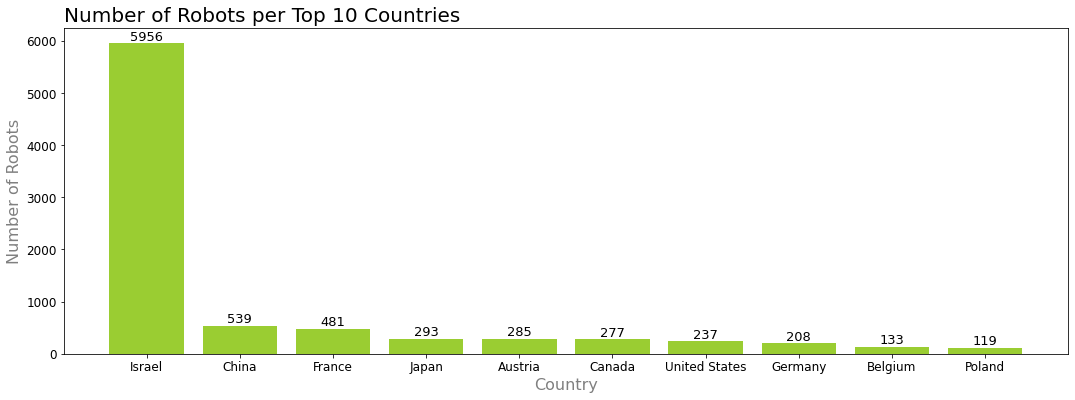

In [53]:
fig, ax = plt.subplots(figsize=(18,6))

bars = ax.bar(country_robot_count.index, country_robot_count, color='yellowgreen')

ax.bar_label(bars,label_type='edge',size=13)

plt.xticks(size=12)
plt.yticks(size=12)
# plt.xlabel('Country')
ax.set_xlabel('Country', size = 16, c='grey')
# plt.ylabel('Number of Robots')
ax.set_ylabel('Number of Robots', size=16 ,c='grey')
plt.title("Number of Robots per Top 10 Countries", size =20, loc='left');

## Working through converting GMT to local time and hour of day

In [54]:
mis_geo2.head()

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome,country_cd,timezone,country
0,000NG2FMLJBT9ANZ,2017-10-01 16:17:22,40,3,1,2,stuck,IL,Asia/Jerusalem,Israel
1,000NG2FMLJBT9ANZ,2017-10-03 14:25:56,41,83,0,13,ok,IL,Asia/Jerusalem,Israel
2,000NG2FMLJBT9ANZ,2017-10-04 12:32:51,42,66,13,12,ok,IL,Asia/Jerusalem,Israel
3,000NG2FMLJBT9ANZ,2017-10-26 02:12:55,45,72,24,0,cncl,IL,Asia/Jerusalem,Israel
4,000NG2FMLJBT9ANZ,2017-10-27 07:17:39,46,61,9,0,cncl,IL,Asia/Jerusalem,Israel


In [55]:
# Write a function to convert UTC to Local Time using datetime and timezone inputs
def utc_to_local(df_datetime, df_timezone):
    
#     utc_time = datetime.utcnow()
# # The following accepts a string input and converts it to a datetime
#     utc_time = datetime.strptime(df_datetime,'%Y-%m-%d %H:%M:%S')

    # Because I previously converted the datetime column to a datetime object,
    # I need to convert it to a string for this function to work
    utc_time = datetime.strptime(str(df_datetime), '%Y-%m-%d %H:%M:%S') 
    # Return a dateime.tzinfo implementation for the given timezone
    tz = pytz.timezone(df_timezone)
    # Replace method
    utc_time = utc_time.replace(tzinfo=pytz.UTC)
    # Astimezone method
    local_time = utc_time.astimezone(tz)
    return local_time

In [56]:
mis_geo2[mis_geo2['timezone']=='America/Los_Angeles']

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome,country_cd,timezone,country
4648,0FSBUWPW1RJW8CBQ,2017-05-03 23:17:47,12,53,0,11,ok,US,America/Los_Angeles,United States
4649,0FSBUWPW1RJW8CBQ,2017-05-06 07:31:56,13,18,0,4,cncl,US,America/Los_Angeles,United States
4650,0FSBUWPW1RJW8CBQ,2017-06-03 16:16:53,14,109,0,0,ok,US,America/Los_Angeles,United States
4651,0FSBUWPW1RJW8CBQ,2017-08-11 00:19:10,15,96,0,0,ok,US,America/Los_Angeles,United States
4652,0FSBUWPW1RJW8CBQ,2017-08-16 04:28:17,16,75,0,0,ok,US,America/Los_Angeles,United States
...,...,...,...,...,...,...,...,...,...,...
351550,YFJ909T1YXR8SIX5,2017-01-10 03:40:22,91,99,0,0,ok,US,America/Los_Angeles,United States
351551,YFJ909T1YXR8SIX5,2017-02-09 11:52:13,92,95,0,21,ok,US,America/Los_Angeles,United States
351552,YFJ909T1YXR8SIX5,2017-02-12 05:30:32,93,58,14,0,cncl,US,America/Los_Angeles,United States
351553,YFJ909T1YXR8SIX5,2017-02-16 07:23:56,94,38,0,0,ok,US,America/Los_Angeles,United States


In [57]:
mis_geo2.head()

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome,country_cd,timezone,country
0,000NG2FMLJBT9ANZ,2017-10-01 16:17:22,40,3,1,2,stuck,IL,Asia/Jerusalem,Israel
1,000NG2FMLJBT9ANZ,2017-10-03 14:25:56,41,83,0,13,ok,IL,Asia/Jerusalem,Israel
2,000NG2FMLJBT9ANZ,2017-10-04 12:32:51,42,66,13,12,ok,IL,Asia/Jerusalem,Israel
3,000NG2FMLJBT9ANZ,2017-10-26 02:12:55,45,72,24,0,cncl,IL,Asia/Jerusalem,Israel
4,000NG2FMLJBT9ANZ,2017-10-27 07:17:39,46,61,9,0,cncl,IL,Asia/Jerusalem,Israel


In [58]:
# Got this to work!
mis_geo2['local_time'] = mis_geo2.apply(lambda x: utc_to_local(x['datetime'], x['timezone']), axis=1)
mis_geo2.head()

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome,country_cd,timezone,country,local_time
0,000NG2FMLJBT9ANZ,2017-10-01 16:17:22,40,3,1,2,stuck,IL,Asia/Jerusalem,Israel,2017-10-01 19:17:22+03:00
1,000NG2FMLJBT9ANZ,2017-10-03 14:25:56,41,83,0,13,ok,IL,Asia/Jerusalem,Israel,2017-10-03 17:25:56+03:00
2,000NG2FMLJBT9ANZ,2017-10-04 12:32:51,42,66,13,12,ok,IL,Asia/Jerusalem,Israel,2017-10-04 15:32:51+03:00
3,000NG2FMLJBT9ANZ,2017-10-26 02:12:55,45,72,24,0,cncl,IL,Asia/Jerusalem,Israel,2017-10-26 05:12:55+03:00
4,000NG2FMLJBT9ANZ,2017-10-27 07:17:39,46,61,9,0,cncl,IL,Asia/Jerusalem,Israel,2017-10-27 10:17:39+03:00


In [59]:
mis_geo2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 367679 entries, 0 to 367678
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   robotid     367679 non-null  object        
 1   datetime    367679 non-null  datetime64[ns]
 2   nmssn       367679 non-null  int64         
 3   runm        367679 non-null  int64         
 4   chrgm       367679 non-null  int64         
 5   pausem      367679 non-null  int64         
 6   outcome     367679 non-null  object        
 7   country_cd  367679 non-null  object        
 8   timezone    367679 non-null  object        
 9   country     367671 non-null  object        
 10  local_time  367679 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(6)
memory usage: 33.7+ MB


In [60]:
mis_geo2.head()

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome,country_cd,timezone,country,local_time
0,000NG2FMLJBT9ANZ,2017-10-01 16:17:22,40,3,1,2,stuck,IL,Asia/Jerusalem,Israel,2017-10-01 19:17:22+03:00
1,000NG2FMLJBT9ANZ,2017-10-03 14:25:56,41,83,0,13,ok,IL,Asia/Jerusalem,Israel,2017-10-03 17:25:56+03:00
2,000NG2FMLJBT9ANZ,2017-10-04 12:32:51,42,66,13,12,ok,IL,Asia/Jerusalem,Israel,2017-10-04 15:32:51+03:00
3,000NG2FMLJBT9ANZ,2017-10-26 02:12:55,45,72,24,0,cncl,IL,Asia/Jerusalem,Israel,2017-10-26 05:12:55+03:00
4,000NG2FMLJBT9ANZ,2017-10-27 07:17:39,46,61,9,0,cncl,IL,Asia/Jerusalem,Israel,2017-10-27 10:17:39+03:00


In [61]:
mis_geo2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 367679 entries, 0 to 367678
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   robotid     367679 non-null  object        
 1   datetime    367679 non-null  datetime64[ns]
 2   nmssn       367679 non-null  int64         
 3   runm        367679 non-null  int64         
 4   chrgm       367679 non-null  int64         
 5   pausem      367679 non-null  int64         
 6   outcome     367679 non-null  object        
 7   country_cd  367679 non-null  object        
 8   timezone    367679 non-null  object        
 9   country     367671 non-null  object        
 10  local_time  367679 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(6)
memory usage: 33.7+ MB


In [62]:
mis_geo2['hour_of_day'] = mis_geo2['local_time'].astype(str)

In [63]:
mis_geo2.head()

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome,country_cd,timezone,country,local_time,hour_of_day
0,000NG2FMLJBT9ANZ,2017-10-01 16:17:22,40,3,1,2,stuck,IL,Asia/Jerusalem,Israel,2017-10-01 19:17:22+03:00,2017-10-01 19:17:22+03:00
1,000NG2FMLJBT9ANZ,2017-10-03 14:25:56,41,83,0,13,ok,IL,Asia/Jerusalem,Israel,2017-10-03 17:25:56+03:00,2017-10-03 17:25:56+03:00
2,000NG2FMLJBT9ANZ,2017-10-04 12:32:51,42,66,13,12,ok,IL,Asia/Jerusalem,Israel,2017-10-04 15:32:51+03:00,2017-10-04 15:32:51+03:00
3,000NG2FMLJBT9ANZ,2017-10-26 02:12:55,45,72,24,0,cncl,IL,Asia/Jerusalem,Israel,2017-10-26 05:12:55+03:00,2017-10-26 05:12:55+03:00
4,000NG2FMLJBT9ANZ,2017-10-27 07:17:39,46,61,9,0,cncl,IL,Asia/Jerusalem,Israel,2017-10-27 10:17:39+03:00,2017-10-27 10:17:39+03:00


In [64]:
mis_geo2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 367679 entries, 0 to 367678
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   robotid      367679 non-null  object        
 1   datetime     367679 non-null  datetime64[ns]
 2   nmssn        367679 non-null  int64         
 3   runm         367679 non-null  int64         
 4   chrgm        367679 non-null  int64         
 5   pausem       367679 non-null  int64         
 6   outcome      367679 non-null  object        
 7   country_cd   367679 non-null  object        
 8   timezone     367679 non-null  object        
 9   country      367671 non-null  object        
 10  local_time   367679 non-null  object        
 11  hour_of_day  367679 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(7)
memory usage: 36.5+ MB


In [65]:
mis_geo2['hour_of_day'][0]

'2017-10-01 19:17:22+03:00'

In [66]:
mis_geo2['hour_of_day'][0].split('-')[2]

'01 19:17:22+03:00'

In [67]:
# Got this to work to get time of day move to initial imports
import re

In [68]:
re.split('[- :]',mis_geo2['hour_of_day'][0])

['2017', '10', '01', '19', '17', '22+03', '00']

In [69]:
re.split('[- :]',mis_geo2['hour_of_day'][0])[3]

'19'

In [70]:
# Extract the hour of the day from the datetime string
mis_geo2['hour_of_day'] = mis_geo2['hour_of_day'].apply(lambda x: re.split('[- :]', x)[3])

In [71]:
mis_geo2.head(15)

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome,country_cd,timezone,country,local_time,hour_of_day
0,000NG2FMLJBT9ANZ,2017-10-01 16:17:22,40,3,1,2,stuck,IL,Asia/Jerusalem,Israel,2017-10-01 19:17:22+03:00,19
1,000NG2FMLJBT9ANZ,2017-10-03 14:25:56,41,83,0,13,ok,IL,Asia/Jerusalem,Israel,2017-10-03 17:25:56+03:00,17
2,000NG2FMLJBT9ANZ,2017-10-04 12:32:51,42,66,13,12,ok,IL,Asia/Jerusalem,Israel,2017-10-04 15:32:51+03:00,15
3,000NG2FMLJBT9ANZ,2017-10-26 02:12:55,45,72,24,0,cncl,IL,Asia/Jerusalem,Israel,2017-10-26 05:12:55+03:00,05
4,000NG2FMLJBT9ANZ,2017-10-27 07:17:39,46,61,9,0,cncl,IL,Asia/Jerusalem,Israel,2017-10-27 10:17:39+03:00,10
5,000Y9NBMJ77LQ7S7,2016-11-28 05:41:25,55,61,0,13,ok,JP,Asia/Tokyo,Japan,2016-11-28 14:41:25+09:00,14
6,000Y9NBMJ77LQ7S7,2016-12-20 10:06:42,56,31,0,6,cncl,JP,Asia/Tokyo,Japan,2016-12-20 19:06:42+09:00,19
7,000Y9NBMJ77LQ7S7,2017-02-18 03:16:40,57,11,0,2,cncl,JP,Asia/Tokyo,Japan,2017-02-18 12:16:40+09:00,12
8,000Y9NBMJ77LQ7S7,2017-03-08 10:49:36,58,78,0,0,ok,JP,Asia/Tokyo,Japan,2017-03-08 19:49:36+09:00,19
9,000Y9NBMJ77LQ7S7,2017-03-19 10:21:15,59,99,0,0,cncl,JP,Asia/Tokyo,Japan,2017-03-19 19:21:15+09:00,19


In [72]:
mis_geo2[mis_geo2['timezone']=='America/Los_Angeles']

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome,country_cd,timezone,country,local_time,hour_of_day
4648,0FSBUWPW1RJW8CBQ,2017-05-03 23:17:47,12,53,0,11,ok,US,America/Los_Angeles,United States,2017-05-03 16:17:47-07:00,16
4649,0FSBUWPW1RJW8CBQ,2017-05-06 07:31:56,13,18,0,4,cncl,US,America/Los_Angeles,United States,2017-05-06 00:31:56-07:00,00
4650,0FSBUWPW1RJW8CBQ,2017-06-03 16:16:53,14,109,0,0,ok,US,America/Los_Angeles,United States,2017-06-03 09:16:53-07:00,09
4651,0FSBUWPW1RJW8CBQ,2017-08-11 00:19:10,15,96,0,0,ok,US,America/Los_Angeles,United States,2017-08-10 17:19:10-07:00,17
4652,0FSBUWPW1RJW8CBQ,2017-08-16 04:28:17,16,75,0,0,ok,US,America/Los_Angeles,United States,2017-08-15 21:28:17-07:00,21
...,...,...,...,...,...,...,...,...,...,...,...,...
351550,YFJ909T1YXR8SIX5,2017-01-10 03:40:22,91,99,0,0,ok,US,America/Los_Angeles,United States,2017-01-09 19:40:22-08:00,19
351551,YFJ909T1YXR8SIX5,2017-02-09 11:52:13,92,95,0,21,ok,US,America/Los_Angeles,United States,2017-02-09 03:52:13-08:00,03
351552,YFJ909T1YXR8SIX5,2017-02-12 05:30:32,93,58,14,0,cncl,US,America/Los_Angeles,United States,2017-02-11 21:30:32-08:00,21
351553,YFJ909T1YXR8SIX5,2017-02-16 07:23:56,94,38,0,0,ok,US,America/Los_Angeles,United States,2017-02-15 23:23:56-08:00,23


## Create visuals for Country vs. Outcome

In [73]:
top_countries = ['Israel', 'China', 'France', 'Japan', 'Austria', 'Canada', 'United States', 'Germany',
                   'Belgium', 'Poland']

In [74]:
list_of_df = []

for country in top_countries:
    list_of_df.append(mis_geo2.loc[mis_geo2['country']== country,:])

In [75]:
israel = list_of_df[0]
china = list_of_df[1]
france = list_of_df[2]
japan = list_of_df[3]
austria = list_of_df[4]
canada = list_of_df[5]
united_states = list_of_df[6]
germany = list_of_df[7]
belgium = list_of_df[8]
poland = list_of_df[9]

In [76]:
china.head()

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome,country_cd,timezone,country,local_time,hour_of_day
277,024GL5LMHXQ4AXA5,2017-08-03 08:52:05,22,34,0,0,ok,CN,Asia/Shanghai,China,2017-08-03 16:52:05+08:00,16
278,024GL5LMHXQ4AXA5,2017-08-03 02:39:11,23,66,0,0,ok,CN,Asia/Shanghai,China,2017-08-03 10:39:11+08:00,10
279,024GL5LMHXQ4AXA5,2017-08-03 05:49:15,24,4,0,0,ok,CN,Asia/Shanghai,China,2017-08-03 13:49:15+08:00,13
280,024GL5LMHXQ4AXA5,2017-08-03 02:47:32,25,67,0,0,ok,CN,Asia/Shanghai,China,2017-08-03 10:47:32+08:00,10
281,024GL5LMHXQ4AXA5,2017-08-02 19:50:49,28,41,0,0,ok,CN,Asia/Shanghai,China,2017-08-03 03:50:49+08:00,03


In [77]:
poland.head()

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome,country_cd,timezone,country,local_time,hour_of_day
6604,0LZR5EBE1Q9AMOGK,2017-01-01 09:04:47,59,66,0,0,ok,PL,Europe/Warsaw,Poland,2017-01-01 10:04:47+01:00,10
6605,0LZR5EBE1Q9AMOGK,2017-01-02 08:12:23,60,15,0,3,ok,PL,Europe/Warsaw,Poland,2017-01-02 09:12:23+01:00,09
6606,0LZR5EBE1Q9AMOGK,2017-01-04 21:53:55,61,13,3,0,ok,PL,Europe/Warsaw,Poland,2017-01-04 22:53:55+01:00,22
6607,0LZR5EBE1Q9AMOGK,2017-01-07 06:36:46,62,114,0,0,ok,PL,Europe/Warsaw,Poland,2017-01-07 07:36:46+01:00,07
6608,0LZR5EBE1Q9AMOGK,2017-01-07 22:41:24,63,51,0,11,ok,PL,Europe/Warsaw,Poland,2017-01-07 23:41:24+01:00,23


In [78]:
# Graph the count of outcomes per country for the top 10 countries
# outcome_per_country = mis_geo2.groupby('country')['outcome'].nunique().sort_values(ascending=False).head(10)
# outcome_per_country.head()
mis_geo2.groupby('country')['outcome'].value_counts()

country                            outcome
Andorra                            ok         36
                                   cncl       14
Antigua and Barbuda                cncl        3
                                   ok          3
                                   bat         1
                                              ..
Venezuela, Bolivarian Republic of  ok          1
Viet Nam                           ok         88
                                   cncl       35
                                   stuck       3
                                   bat         1
Name: outcome, Length: 317, dtype: int64

In [79]:
top_10_countries = mis_geo2[mis_geo2['country'].isin(top_countries)]
top_10_countries.head()

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome,country_cd,timezone,country,local_time,hour_of_day
0,000NG2FMLJBT9ANZ,2017-10-01 16:17:22,40,3,1,2,stuck,IL,Asia/Jerusalem,Israel,2017-10-01 19:17:22+03:00,19
1,000NG2FMLJBT9ANZ,2017-10-03 14:25:56,41,83,0,13,ok,IL,Asia/Jerusalem,Israel,2017-10-03 17:25:56+03:00,17
2,000NG2FMLJBT9ANZ,2017-10-04 12:32:51,42,66,13,12,ok,IL,Asia/Jerusalem,Israel,2017-10-04 15:32:51+03:00,15
3,000NG2FMLJBT9ANZ,2017-10-26 02:12:55,45,72,24,0,cncl,IL,Asia/Jerusalem,Israel,2017-10-26 05:12:55+03:00,05
4,000NG2FMLJBT9ANZ,2017-10-27 07:17:39,46,61,9,0,cncl,IL,Asia/Jerusalem,Israel,2017-10-27 10:17:39+03:00,10


In [80]:
# Trying to set a specific order
top_10_countries['country'] = pd.Categorical(top_10_countries['country'],
                                             categories=['Israel', 'China', 'France', 'Japan', 'Austria', 
                                                         'Canada', 'United States', 'Germany', 'Belgium', 
                                                         'Poland'])

/var/folders/c9/kmqtft5n5dzdbw3r5rghf2qxj6_kz9/T/ipykernel_73012/2564082485.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_countries['country'] = pd.Categorical(top_10_countries['country'],


In [81]:
top_10_countries.head()

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome,country_cd,timezone,country,local_time,hour_of_day
0,000NG2FMLJBT9ANZ,2017-10-01 16:17:22,40,3,1,2,stuck,IL,Asia/Jerusalem,Israel,2017-10-01 19:17:22+03:00,19
1,000NG2FMLJBT9ANZ,2017-10-03 14:25:56,41,83,0,13,ok,IL,Asia/Jerusalem,Israel,2017-10-03 17:25:56+03:00,17
2,000NG2FMLJBT9ANZ,2017-10-04 12:32:51,42,66,13,12,ok,IL,Asia/Jerusalem,Israel,2017-10-04 15:32:51+03:00,15
3,000NG2FMLJBT9ANZ,2017-10-26 02:12:55,45,72,24,0,cncl,IL,Asia/Jerusalem,Israel,2017-10-26 05:12:55+03:00,05
4,000NG2FMLJBT9ANZ,2017-10-27 07:17:39,46,61,9,0,cncl,IL,Asia/Jerusalem,Israel,2017-10-27 10:17:39+03:00,10


In [82]:
# top_10_countries = ['Israel', 'China', 'France', 'Japan', 'Austria', 'Canada', 'United States', 'Germany',
#                    'Belgium', 'Poland']

# The top 9 countries not including Israel
top_9_countries = ['China', 'France', 'Japan', 'Austria', 'Canada', 'United States', 'Germany',
                   'Belgium', 'Poland']

top_9 = mis_geo2[mis_geo2['country'].isin(top_9_countries)]
top_9['country'].value_counts()

China            21054
France           17719
Japan            11743
Canada           11126
Austria          10558
Germany           8284
United States     8221
Belgium           5123
Poland            4388
Name: country, dtype: int64

In [83]:
top_9.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98216 entries, 5 to 367613
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   robotid      98216 non-null  object        
 1   datetime     98216 non-null  datetime64[ns]
 2   nmssn        98216 non-null  int64         
 3   runm         98216 non-null  int64         
 4   chrgm        98216 non-null  int64         
 5   pausem       98216 non-null  int64         
 6   outcome      98216 non-null  object        
 7   country_cd   98216 non-null  object        
 8   timezone     98216 non-null  object        
 9   country      98216 non-null  object        
 10  local_time   98216 non-null  object        
 11  hour_of_day  98216 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(7)
memory usage: 9.7+ MB


In [84]:
top_9.head()

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome,country_cd,timezone,country,local_time,hour_of_day
5,000Y9NBMJ77LQ7S7,2016-11-28 05:41:25,55,61,0,13,ok,JP,Asia/Tokyo,Japan,2016-11-28 14:41:25+09:00,14
6,000Y9NBMJ77LQ7S7,2016-12-20 10:06:42,56,31,0,6,cncl,JP,Asia/Tokyo,Japan,2016-12-20 19:06:42+09:00,19
7,000Y9NBMJ77LQ7S7,2017-02-18 03:16:40,57,11,0,2,cncl,JP,Asia/Tokyo,Japan,2017-02-18 12:16:40+09:00,12
8,000Y9NBMJ77LQ7S7,2017-03-08 10:49:36,58,78,0,0,ok,JP,Asia/Tokyo,Japan,2017-03-08 19:49:36+09:00,19
9,000Y9NBMJ77LQ7S7,2017-03-19 10:21:15,59,99,0,0,cncl,JP,Asia/Tokyo,Japan,2017-03-19 19:21:15+09:00,19


In [85]:
top_9_outcomes = top_9.groupby('country')['outcome'].value_counts()

In [86]:
# change the name of outcome and then reset index
top_9_outcomes.to_frame()

outcome
country       outcome         
Austria       ok          6512
              cncl        3020
              stuck        775
              bat          251
Belgium       ok          3141
              cncl        1501
              stuck        365
              bat          116
Canada        ok          6903
              cncl        3134
              stuck        856
              bat          233
China         ok         13882
              cncl        5946
              stuck        780
              bat          446
France        ok         11023
              cncl        4926
              stuck       1398
              bat          372
Germany       ok          5097
              cncl        2468
              stuck        542
              bat          177
Japan         ok          7185
              cncl        3434
              stuck        860
              bat          264
Poland        ok          2678
              cncl        1246
              stuck        353
              bat          111
United States ok          5182
              cncl        2310
              stuck        560
              bat          169

In [87]:
top_9_outcomes.index

MultiIndex([(      'Austria',    'ok'),
            (      'Austria',  'cncl'),
            (      'Austria', 'stuck'),
            (      'Austria',   'bat'),
            (      'Belgium',    'ok'),
            (      'Belgium',  'cncl'),
            (      'Belgium', 'stuck'),
            (      'Belgium',   'bat'),
            (       'Canada',    'ok'),
            (       'Canada',  'cncl'),
            (       'Canada', 'stuck'),
            (       'Canada',   'bat'),
            (        'China',    'ok'),
            (        'China',  'cncl'),
            (        'China', 'stuck'),
            (        'China',   'bat'),
            (       'France',    'ok'),
            (       'France',  'cncl'),
            (       'France', 'stuck'),
            (       'France',   'bat'),
            (      'Germany',    'ok'),
            (      'Germany',  'cncl'),
            (      'Germany', 'stuck'),
            (      'Germany',   'bat'),
            (        'Japan',    'ok'),


In [88]:
type(top_9_outcomes)

pandas.core.series.Series

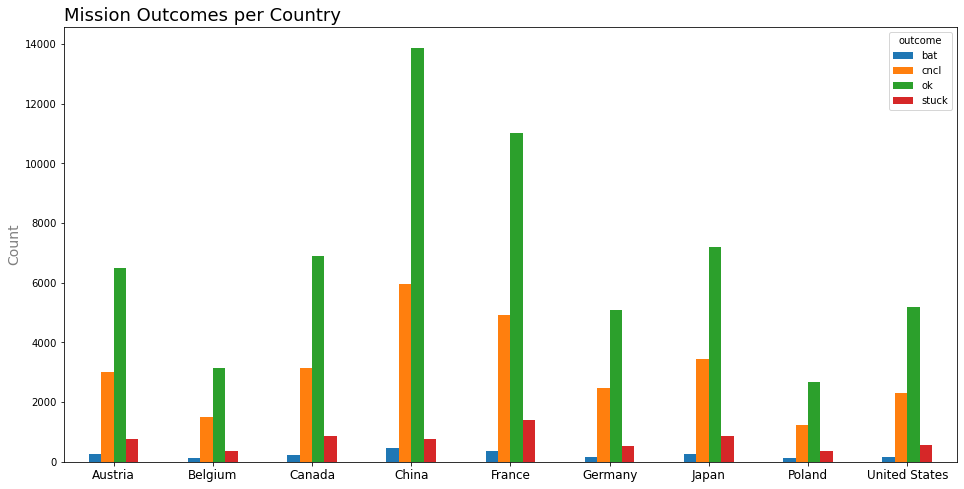

In [89]:
top_9_outcomes.unstack().plot(kind='bar', figsize=(16,8))


plt.xticks(rotation = 0, size=12)
plt.xlabel("")
plt.ylabel("Count", size=14, c='grey')
plt.title('Mission Outcomes per Country', size=18, loc='left');

In [90]:
# # top_10_countries = ['Israel', 'China', 'France', 'Japan', 'Austria', 'Canada', 'United States', 'Germany',
# #                    'Belgium', 'Poland']

# top_c = ['Israel']

# top_country = mis_geo2[mis_geo2['country'].isin(top_c)]
# top_country['country'].value_counts()

In [91]:
# top_country.head()

In [92]:
israel_outcomes = israel.groupby('country')['outcome'].value_counts()

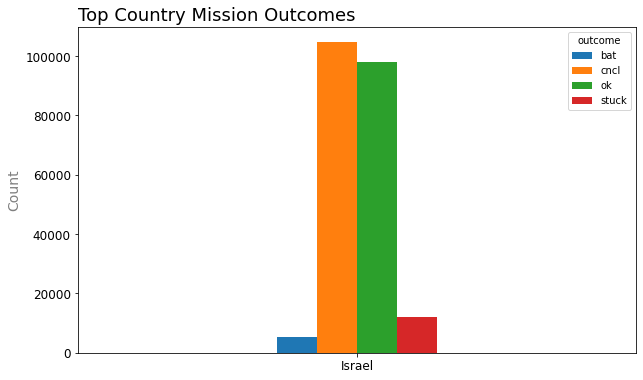

In [93]:
israel_outcomes.unstack().plot(kind='bar', width=0.2, figsize=(10,6))

plt.yticks(size=12)
plt.xticks(rotation = 0, size=12)
plt.xlabel("")
plt.ylabel("Count", size=14, c='grey')
plt.title('Top Country Mission Outcomes', size=18, loc='left');

## and Country vs. Time of Day Use

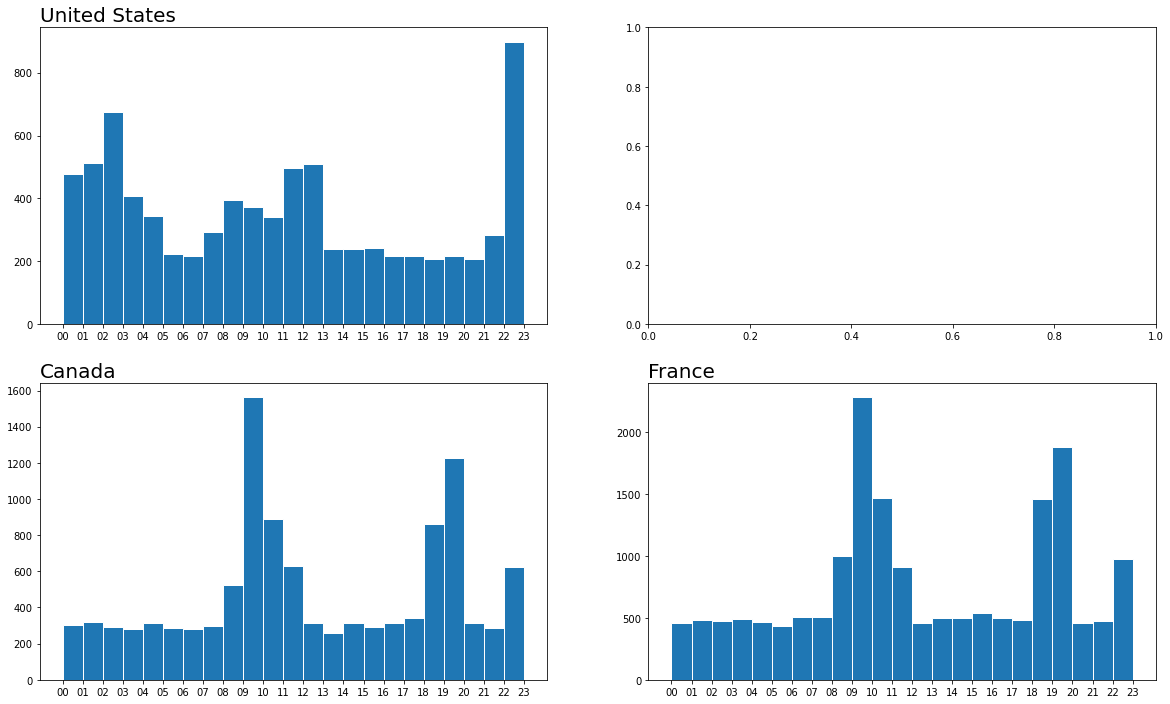

In [94]:
fig, axs = plt.subplots(2, 2, figsize=(20, 12))
axs[0][0].hist(united_states.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[0][0].set_title('United States', loc='left', size=20)

# axs[0][1].plot(ff.Date, ff.MCD, color='red', linewidth=3)
# axs[0][1].set_title('McDonald\'s', loc='left', size=20)

axs[1][0].hist(canada.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[1][0].set_title('Canada', loc='left', size=20);

axs[1][1].hist(list_of_df[2].hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[1][1].set_title('France', loc='left', size=20);

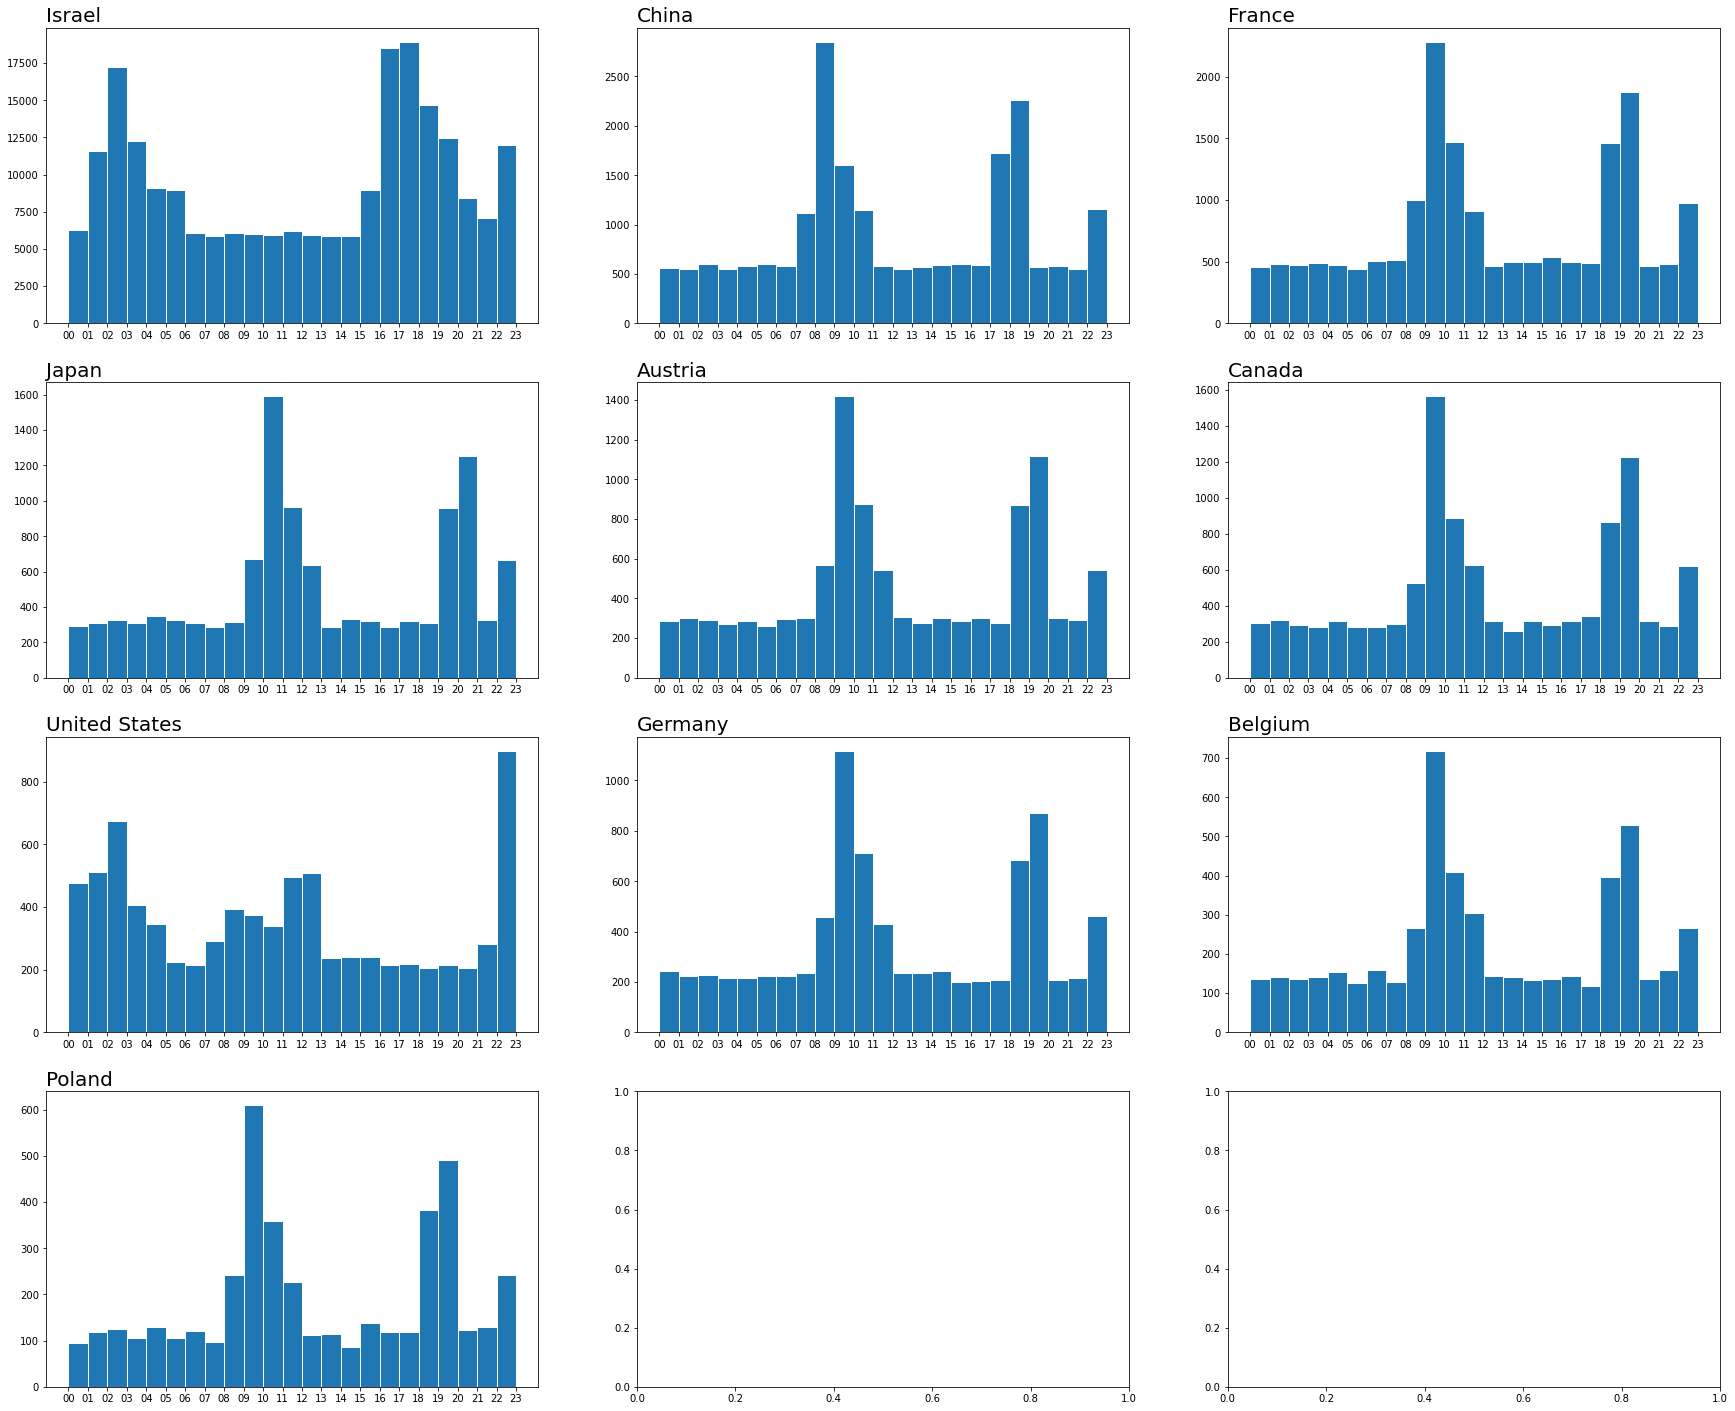

In [95]:
fig, axs = plt.subplots(4, 3, figsize=(30, 25))

axs[0][0].hist(israel.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[0][0].set_title('Israel', loc='left', size=20)

axs[0][1].hist(china.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[0][1].set_title('China', loc='left', size=20)

axs[0][2].hist(france.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[0][2].set_title('France', loc='left', size=20)

axs[1][0].hist(japan.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[1][0].set_title('Japan', loc='left', size=20)

axs[1][1].hist(austria.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[1][1].set_title('Austria', loc='left', size=20)

axs[1][2].hist(canada.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[1][2].set_title('Canada', loc='left', size=20)

axs[2][0].hist(united_states.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[2][0].set_title('United States', loc='left', size=20)

axs[2][1].hist(germany.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[2][1].set_title('Germany', loc='left', size=20)

axs[2][2].hist(belgium.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[2][2].set_title('Belgium', loc='left', size=20)

axs[3][0].hist(poland.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[3][0].set_title('Poland', loc='left', size=20);

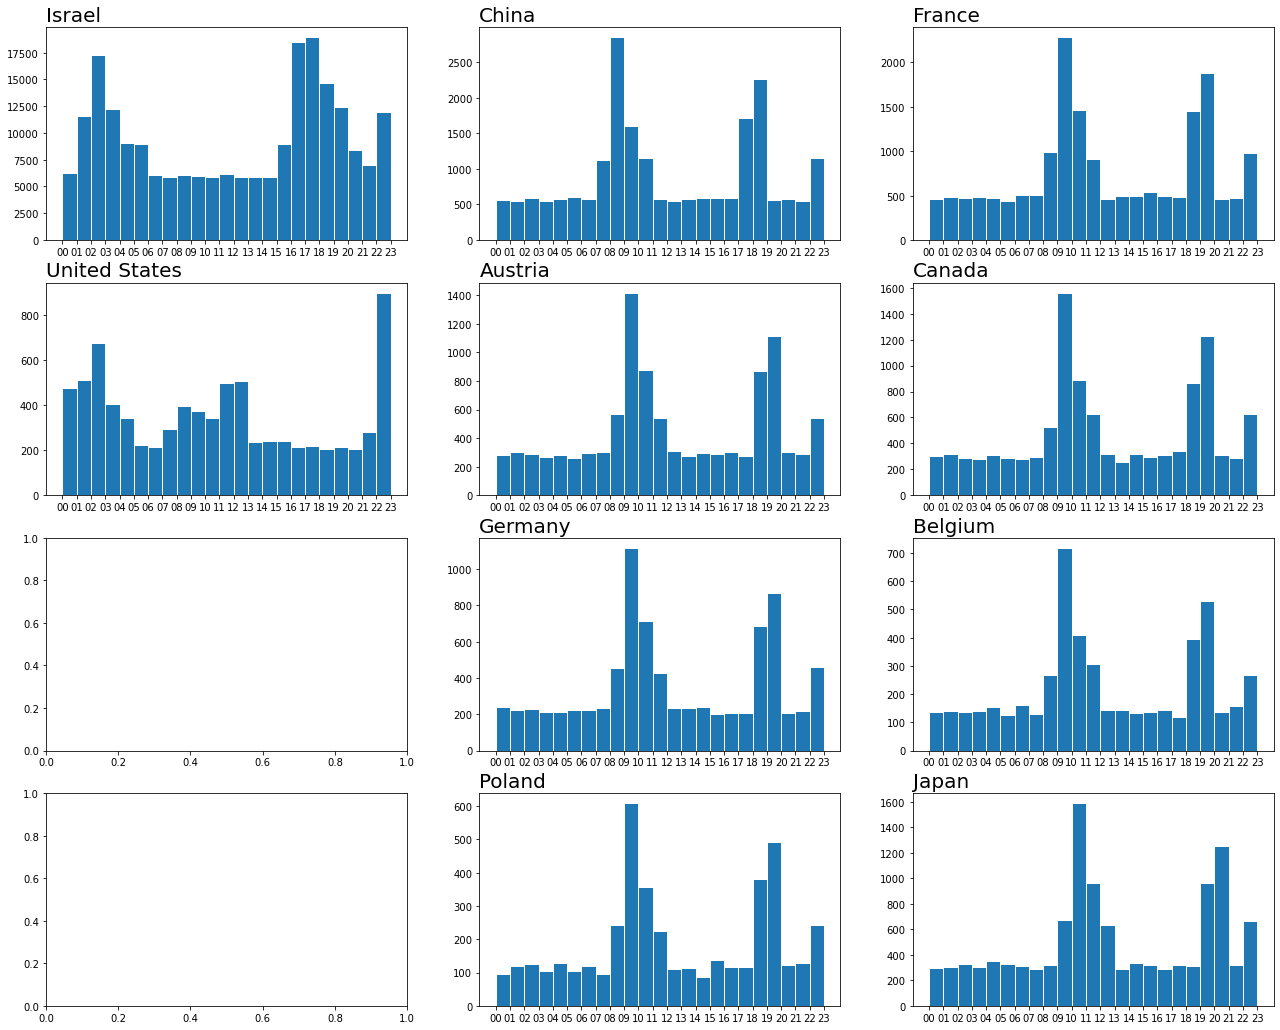

In [96]:
fig, axs = plt.subplots(4, 3, figsize=(22, 18))

axs[0][0].hist(israel.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[0][0].set_title('Israel', loc='left', size=20)

axs[0][1].hist(china.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[0][1].set_title('China', loc='left', size=20)

axs[0][2].hist(france.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[0][2].set_title('France', loc='left', size=20)

axs[3][2].hist(japan.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[3][2].set_title('Japan', loc='left', size=20)

axs[1][1].hist(austria.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[1][1].set_title('Austria', loc='left', size=20);

axs[1][2].hist(canada.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[1][2].set_title('Canada', loc='left', size=20)

axs[1][0].hist(united_states.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[1][0].set_title('United States', loc='left', size=20)

axs[2][1].hist(germany.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[2][1].set_title('Germany', loc='left', size=20)

axs[2][2].hist(belgium.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[2][2].set_title('Belgium', loc='left', size=20)

axs[3][1].hist(poland.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[3][1].set_title('Poland', loc='left', size=20);

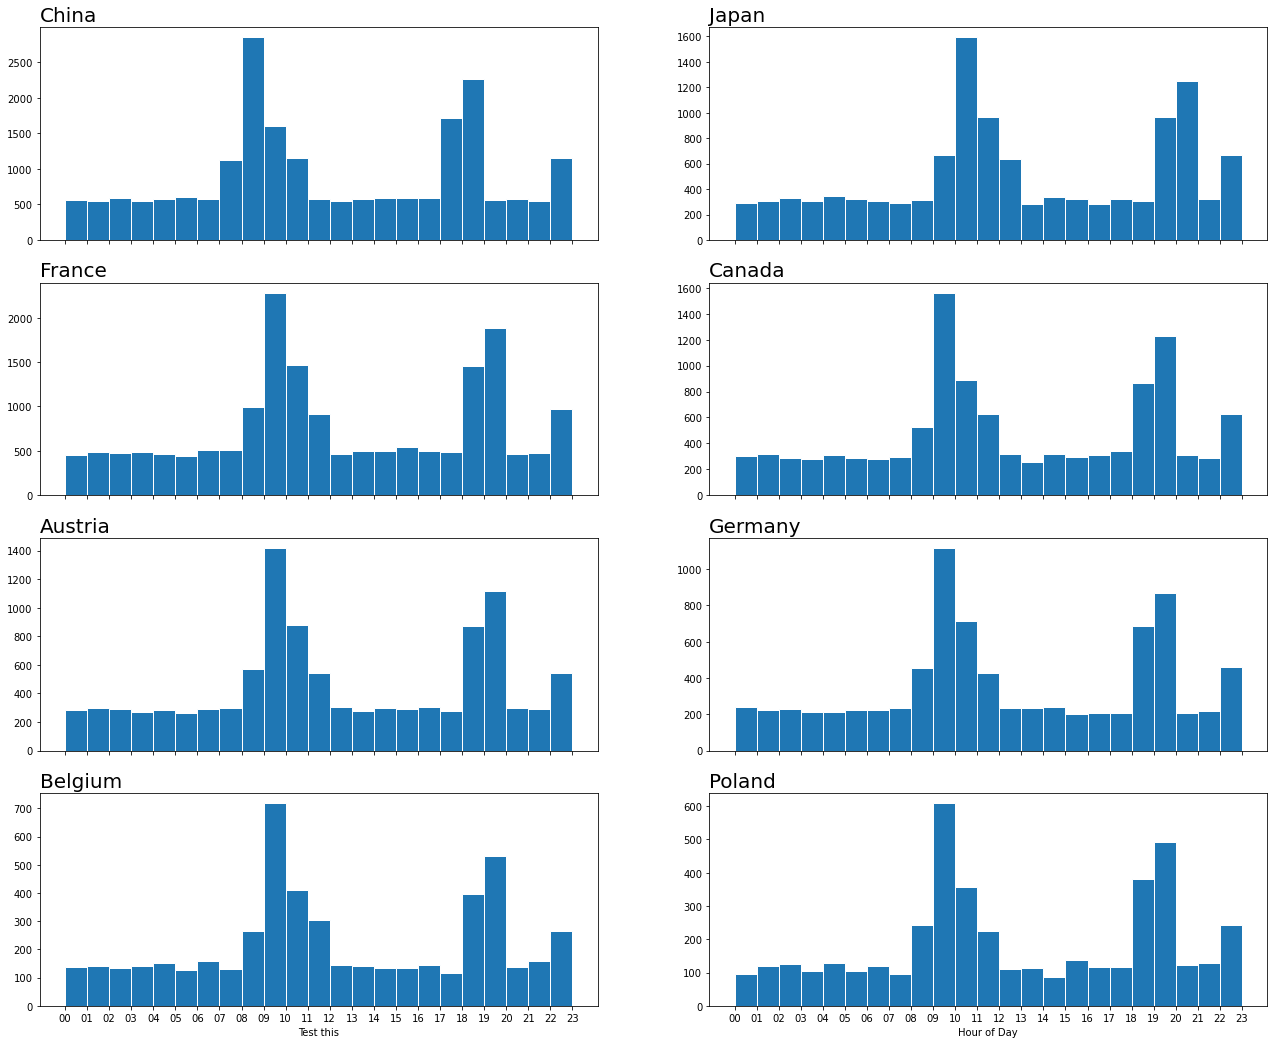

In [97]:
fig, axs = plt.subplots(4, 2, figsize=(22, 18), sharex=True)

# axs[0][0].hist(israel.hour_of_day.sort_values(), edgecolor='white', bins=23)
# axs[0][0].set_title('Israel', loc='left', size=20)

axs[0][0].hist(china.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[0][0].set_title('China', loc='left', size=20)

axs[1][0].hist(france.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[1][0].set_title('France', loc='left', size=20)

axs[0][1].hist(japan.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[0][1].set_title('Japan', loc='left', size=20)

axs[2][0].hist(austria.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[2][0].set_title('Austria', loc='left', size=20);

axs[1][1].hist(canada.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[1][1].set_title('Canada', loc='left', size=20)

# axs[1][0].hist(united_states.hour_of_day.sort_values(), edgecolor='white', bins=23)
# axs[1][0].set_title('United States', loc='left', size=20)

axs[2][1].hist(germany.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[2][1].set_title('Germany', loc='left', size=20)

axs[3][0].hist(belgium.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[3][0].set_title('Belgium', loc='left', size=20)
axs[3][0].set_xlabel("Test this")

axs[3][1].hist(poland.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[3][1].set_title('Poland', loc='left', size=20)

plt.xlabel('Hour of Day');

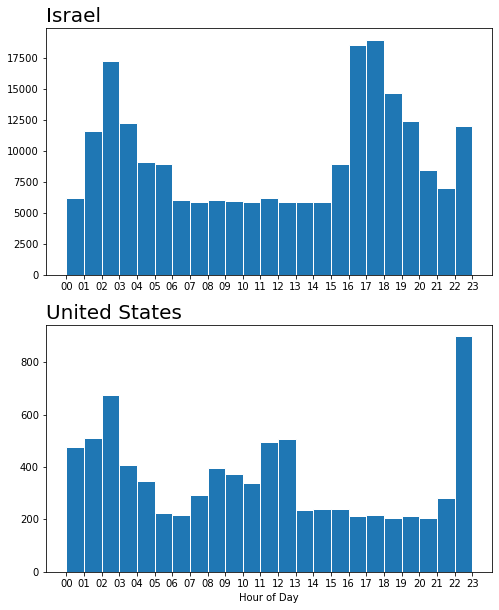

In [98]:
fig, axs = plt.subplots(2, 1, figsize=(8, 10))

axs[0].hist(israel.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[0].set_title('Israel', loc='left', size=20)

axs[1].hist(united_states.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[1].set_title('United States', loc='left', size=20)

plt.xlabel('Hour of Day');

## Create boxplots for Top 10 Countries for runm, chargem, pausem, nmssn

In [99]:
top_10_countries.head()

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome,country_cd,timezone,country,local_time,hour_of_day
0,000NG2FMLJBT9ANZ,2017-10-01 16:17:22,40,3,1,2,stuck,IL,Asia/Jerusalem,Israel,2017-10-01 19:17:22+03:00,19
1,000NG2FMLJBT9ANZ,2017-10-03 14:25:56,41,83,0,13,ok,IL,Asia/Jerusalem,Israel,2017-10-03 17:25:56+03:00,17
2,000NG2FMLJBT9ANZ,2017-10-04 12:32:51,42,66,13,12,ok,IL,Asia/Jerusalem,Israel,2017-10-04 15:32:51+03:00,15
3,000NG2FMLJBT9ANZ,2017-10-26 02:12:55,45,72,24,0,cncl,IL,Asia/Jerusalem,Israel,2017-10-26 05:12:55+03:00,05
4,000NG2FMLJBT9ANZ,2017-10-27 07:17:39,46,61,9,0,cncl,IL,Asia/Jerusalem,Israel,2017-10-27 10:17:39+03:00,10


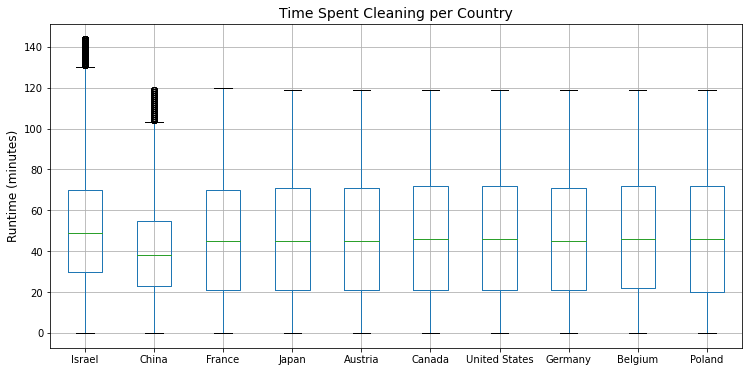

In [100]:
# These get very messy and are difficult to edit.
top_10_countries.boxplot(by='country', column='runm', figsize=(12,6), fontsize=10)

plt.title('Time Spent Cleaning per Country', size =14)
plt.suptitle('')
plt.ylabel('Runtime (minutes)', size = 12)
plt.xlabel('');

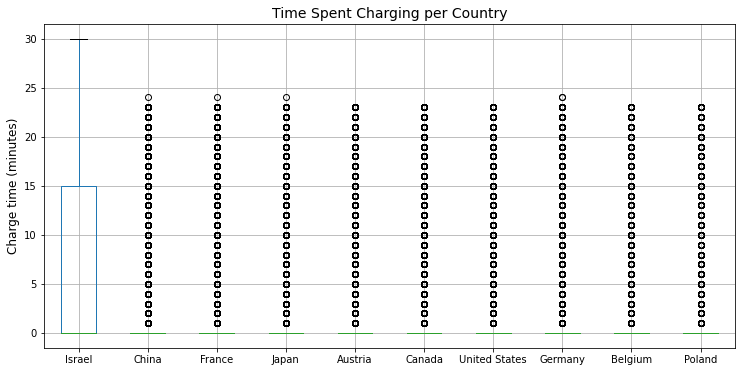

In [101]:
top_10_countries.boxplot(by='country', column='chrgm', figsize=(12,6), fontsize=10)

plt.title('Time Spent Charging per Country', size =14)
plt.suptitle('')
plt.ylabel('Charge time (minutes)', size = 12)
plt.xlabel('');

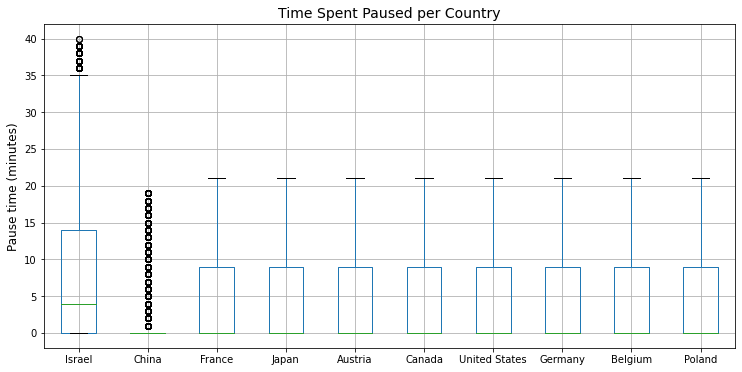

In [102]:
top_10_countries.boxplot(by='country', column='pausem', figsize=(12,6), fontsize=10)

plt.title('Time Spent Paused per Country', size =14)
plt.suptitle('')
plt.ylabel('Pause time (minutes)', size = 12)
plt.xlabel('');

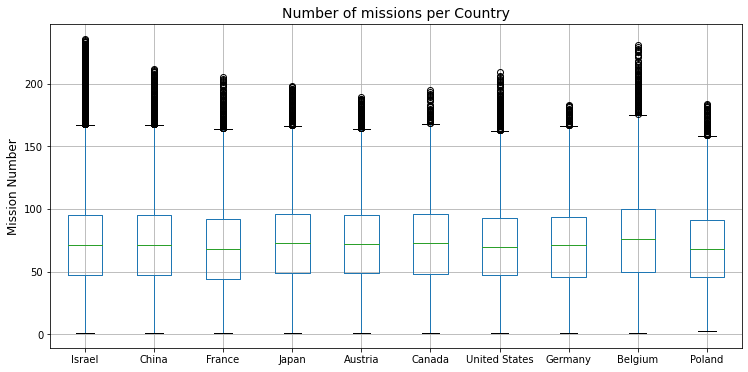

In [103]:
top_10_countries.boxplot(by='country', column='nmssn', figsize=(12,6), fontsize=10)

plt.title('Number of missions per Country', size =14)
plt.suptitle('')
plt.ylabel('Mission Number', size = 12)
plt.xlabel('');

## Create histogram for Top 10 Countries for nmssn

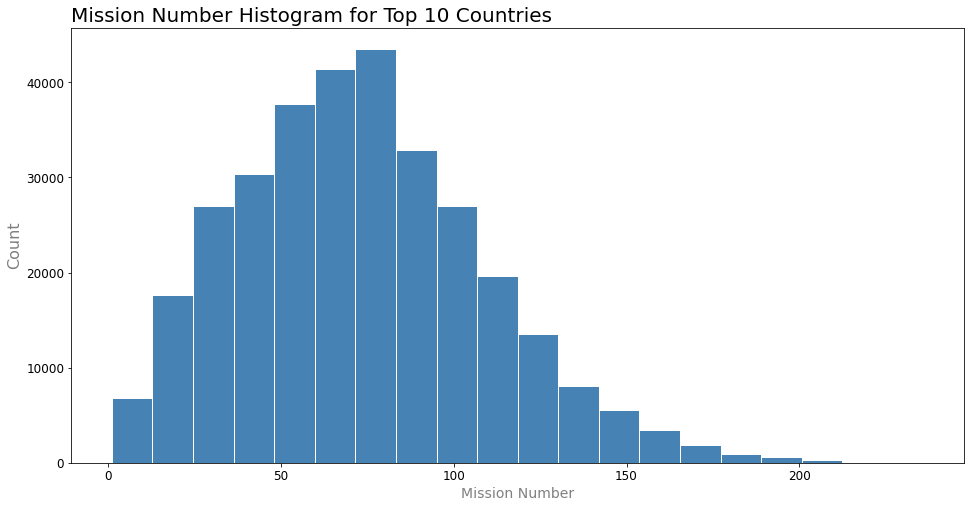

In [104]:
fig, ax = plt.subplots(figsize=(16,8))

ax.hist(top_10_countries.nmssn, edgecolor='white', bins=20, color = 'steelblue')
# bars = ax.bar(country_robot_count.index, country_robot_count, color='yellowgreen')

# ax.bar_label(bars,label_type='edge',size=13)
plt.xticks(size=12)
# plt.xticks(np.arange(0, len(x)+1, 5), size=12)
plt.yticks(size=12)
ax.set_xlabel('Mission Number', size = 14, c='grey')
ax.set_ylabel('Count', size=16 ,c='grey')
plt.title("Mission Number Histogram for Top 10 Countries", size =20, loc='left');

## Create line plot for number of missions over time

In [105]:
top_10_countries.head()

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome,country_cd,timezone,country,local_time,hour_of_day
0,000NG2FMLJBT9ANZ,2017-10-01 16:17:22,40,3,1,2,stuck,IL,Asia/Jerusalem,Israel,2017-10-01 19:17:22+03:00,19
1,000NG2FMLJBT9ANZ,2017-10-03 14:25:56,41,83,0,13,ok,IL,Asia/Jerusalem,Israel,2017-10-03 17:25:56+03:00,17
2,000NG2FMLJBT9ANZ,2017-10-04 12:32:51,42,66,13,12,ok,IL,Asia/Jerusalem,Israel,2017-10-04 15:32:51+03:00,15
3,000NG2FMLJBT9ANZ,2017-10-26 02:12:55,45,72,24,0,cncl,IL,Asia/Jerusalem,Israel,2017-10-26 05:12:55+03:00,05
4,000NG2FMLJBT9ANZ,2017-10-27 07:17:39,46,61,9,0,cncl,IL,Asia/Jerusalem,Israel,2017-10-27 10:17:39+03:00,10


In [106]:
#if the date format comes in datetime, we can also extract the day/month/year using the to_period function
#where 'D', 'M', 'Y' are inputs
top_10_countries['year_month'] = pd.to_datetime(top_10_countries['datetime']).dt.to_period('M').copy()
top_10_countries.head()

/var/folders/c9/kmqtft5n5dzdbw3r5rghf2qxj6_kz9/T/ipykernel_73012/1194711986.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_countries['year_month'] = pd.to_datetime(top_10_countries['datetime']).dt.to_period('M').copy()


,robotid,datetime,nmssn,runm,chrgm,pausem,outcome,country_cd,timezone,country,local_time,hour_of_day,year_month
0,000NG2FMLJBT9ANZ,2017-10-01 16:17:22,40,3,1,2,stuck,IL,Asia/Jerusalem,Israel,2017-10-01 19:17:22+03:00,19,2017-10
1,000NG2FMLJBT9ANZ,2017-10-03 14:25:56,41,83,0,13,ok,IL,Asia/Jerusalem,Israel,2017-10-03 17:25:56+03:00,17,2017-10
2,000NG2FMLJBT9ANZ,2017-10-04 12:32:51,42,66,13,12,ok,IL,Asia/Jerusalem,Israel,2017-10-04 15:32:51+03:00,15,2017-10
3,000NG2FMLJBT9ANZ,2017-10-26 02:12:55,45,72,24,0,cncl,IL,Asia/Jerusalem,Israel,2017-10-26 05:12:55+03:00,05,2017-10
4,000NG2FMLJBT9ANZ,2017-10-27 07:17:39,46,61,9,0,cncl,IL,Asia/Jerusalem,Israel,2017-10-27 10:17:39+03:00,10,2017-10


In [107]:
top_10_countries.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318335 entries, 0 to 367678
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   robotid      318335 non-null  object        
 1   datetime     318335 non-null  datetime64[ns]
 2   nmssn        318335 non-null  int64         
 3   runm         318335 non-null  int64         
 4   chrgm        318335 non-null  int64         
 5   pausem       318335 non-null  int64         
 6   outcome      318335 non-null  object        
 7   country_cd   318335 non-null  object        
 8   timezone     318335 non-null  object        
 9   country      318335 non-null  category      
 10  local_time   318335 non-null  object        
 11  hour_of_day  318335 non-null  object        
 12  year_month   318335 non-null  period[M]     
dtypes: category(1), datetime64[ns](1), int64(4), object(6), period[M](1)
memory usage: 31.9+ MB


In [108]:
top_10_countries['year_month'].sort_values()

323523    2016-01
243758    2016-01
243759    2016-01
243760    2016-01
243761    2016-01
           ...   
159715    2017-12
159716    2017-12
159717    2017-12
159529    2017-12
367678    2017-12
Name: year_month, Length: 318335, dtype: period[M]

In [109]:
top_10_countries['year_month'].min()

Period('2016-01', 'M')

In [110]:
top_10_countries['year_month'].max()

Period('2017-12', 'M')

In [111]:
# Graph the count of unique robots per country for the top 10 countries
mission_robot_count = top_10_countries.groupby('year_month')['robotid'].size()
mission_robot_count

year_month
2016-01     1542
2016-02     3195
2016-03     4974
2016-04     6242
2016-05     7328
2016-06     8537
2016-07     9639
2016-08    10806
2016-09    10957
2016-10    12238
2016-11    12948
2016-12    13860
2017-01    14810
2017-02    14250
2017-03    16321
2017-04    16572
2017-05    17502
2017-06    18096
2017-07    18979
2017-08    19574
2017-09    19709
2017-10    20457
2017-11    20335
2017-12    19464
Freq: M, Name: robotid, dtype: int64

In [112]:
type(mission_robot_count)

pandas.core.series.Series

In [118]:
mission_robot_count.index.to_timestamp()

DatetimeIndex(['2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
               '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01'],
              dtype='datetime64[ns]', name='year_month', freq='MS')

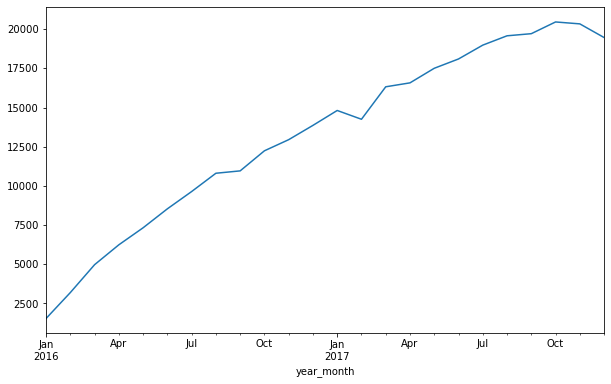

In [114]:
mission_robot_count.plot(figsize=(10,6));

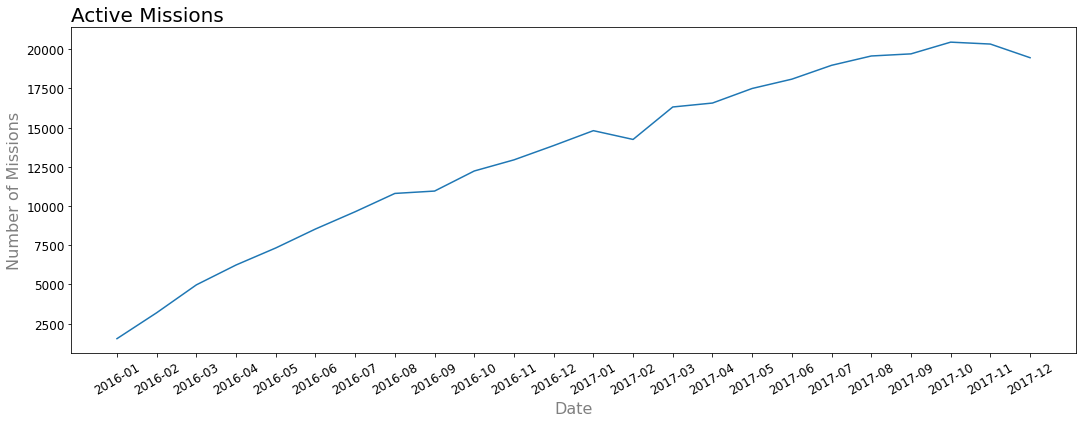

In [116]:
fig, ax = plt.subplots(figsize=(18,6))

plt.plot(mission_robot_count.index.astype(str), mission_robot_count)

plt.xticks(size=12, rotation=30)
plt.yticks(size=12)
ax.set_xlabel('Date', size = 16, c='grey')
ax.set_ylabel('Number of Missions', size=16 ,c='grey')
plt.title("Active Missions", size =20, loc='left');

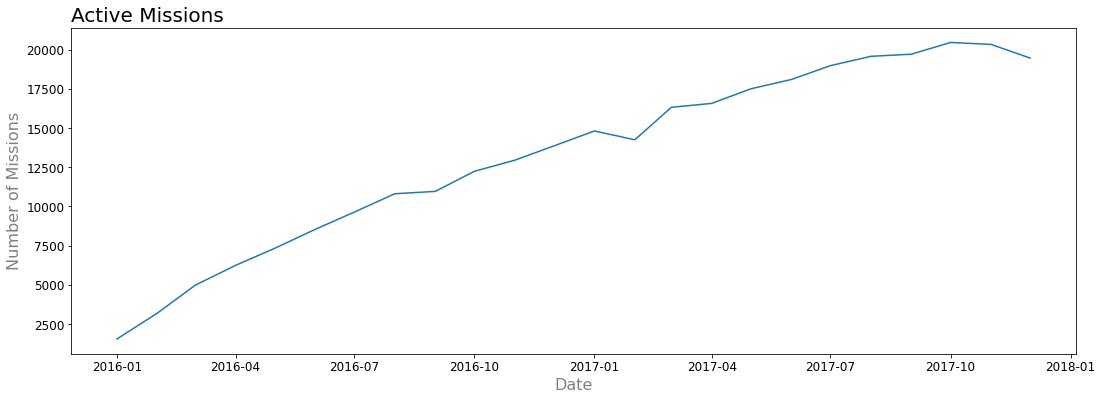

In [120]:
fig, ax = plt.subplots(figsize=(18,6))

plt.plot(mission_robot_count.index.to_timestamp(), mission_robot_count)

plt.xticks(size=12)
plt.yticks(size=12)
ax.set_xlabel('Date', size = 16, c='grey')
ax.set_ylabel('Number of Missions', size=16 ,c='grey')
plt.title("Active Missions", size =20, loc='left');

In [122]:
top_10_active_missions = top_10_countries.groupby('country')['year_month'].value_counts()
top_10_active_missions.to_frame()

year_month
country year_month            
Israel  2017-11          14271
        2017-10          14066
        2017-12          13834
        2017-09          13680
        2017-08          13613
...                        ...
Poland  2016-02             86
        2016-04             78
        2016-09             76
        2016-08             71
        2016-01             51

[240 rows x 1 columns]

In [125]:
israel.head()

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome,country_cd,timezone,country,local_time,hour_of_day
0,000NG2FMLJBT9ANZ,2017-10-01 16:17:22,40,3,1,2,stuck,IL,Asia/Jerusalem,Israel,2017-10-01 19:17:22+03:00,19
1,000NG2FMLJBT9ANZ,2017-10-03 14:25:56,41,83,0,13,ok,IL,Asia/Jerusalem,Israel,2017-10-03 17:25:56+03:00,17
2,000NG2FMLJBT9ANZ,2017-10-04 12:32:51,42,66,13,12,ok,IL,Asia/Jerusalem,Israel,2017-10-04 15:32:51+03:00,15
3,000NG2FMLJBT9ANZ,2017-10-26 02:12:55,45,72,24,0,cncl,IL,Asia/Jerusalem,Israel,2017-10-26 05:12:55+03:00,05
4,000NG2FMLJBT9ANZ,2017-10-27 07:17:39,46,61,9,0,cncl,IL,Asia/Jerusalem,Israel,2017-10-27 10:17:39+03:00,10


In [126]:
china.head()

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome,country_cd,timezone,country,local_time,hour_of_day
277,024GL5LMHXQ4AXA5,2017-08-03 08:52:05,22,34,0,0,ok,CN,Asia/Shanghai,China,2017-08-03 16:52:05+08:00,16
278,024GL5LMHXQ4AXA5,2017-08-03 02:39:11,23,66,0,0,ok,CN,Asia/Shanghai,China,2017-08-03 10:39:11+08:00,10
279,024GL5LMHXQ4AXA5,2017-08-03 05:49:15,24,4,0,0,ok,CN,Asia/Shanghai,China,2017-08-03 13:49:15+08:00,13
280,024GL5LMHXQ4AXA5,2017-08-03 02:47:32,25,67,0,0,ok,CN,Asia/Shanghai,China,2017-08-03 10:47:32+08:00,10
281,024GL5LMHXQ4AXA5,2017-08-02 19:50:49,28,41,0,0,ok,CN,Asia/Shanghai,China,2017-08-03 03:50:49+08:00,03


In [127]:
israel['year_month'] = pd.to_datetime(israel['datetime']).dt.to_period('M')
israel.head()

/var/folders/c9/kmqtft5n5dzdbw3r5rghf2qxj6_kz9/T/ipykernel_73012/3920710713.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  israel['year_month'] = pd.to_datetime(israel['datetime']).dt.to_period('M')


,robotid,datetime,nmssn,runm,chrgm,pausem,outcome,country_cd,timezone,country,local_time,hour_of_day,year_month
0,000NG2FMLJBT9ANZ,2017-10-01 16:17:22,40,3,1,2,stuck,IL,Asia/Jerusalem,Israel,2017-10-01 19:17:22+03:00,19,2017-10
1,000NG2FMLJBT9ANZ,2017-10-03 14:25:56,41,83,0,13,ok,IL,Asia/Jerusalem,Israel,2017-10-03 17:25:56+03:00,17,2017-10
2,000NG2FMLJBT9ANZ,2017-10-04 12:32:51,42,66,13,12,ok,IL,Asia/Jerusalem,Israel,2017-10-04 15:32:51+03:00,15,2017-10
3,000NG2FMLJBT9ANZ,2017-10-26 02:12:55,45,72,24,0,cncl,IL,Asia/Jerusalem,Israel,2017-10-26 05:12:55+03:00,05,2017-10
4,000NG2FMLJBT9ANZ,2017-10-27 07:17:39,46,61,9,0,cncl,IL,Asia/Jerusalem,Israel,2017-10-27 10:17:39+03:00,10,2017-10


In [128]:
china['year_month'] = pd.to_datetime(china['datetime']).dt.to_period('M')
china.head()

/var/folders/c9/kmqtft5n5dzdbw3r5rghf2qxj6_kz9/T/ipykernel_73012/1406324131.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  china['year_month'] = pd.to_datetime(china['datetime']).dt.to_period('M')


,robotid,datetime,nmssn,runm,chrgm,pausem,outcome,country_cd,timezone,country,local_time,hour_of_day,year_month
277,024GL5LMHXQ4AXA5,2017-08-03 08:52:05,22,34,0,0,ok,CN,Asia/Shanghai,China,2017-08-03 16:52:05+08:00,16,2017-08
278,024GL5LMHXQ4AXA5,2017-08-03 02:39:11,23,66,0,0,ok,CN,Asia/Shanghai,China,2017-08-03 10:39:11+08:00,10,2017-08
279,024GL5LMHXQ4AXA5,2017-08-03 05:49:15,24,4,0,0,ok,CN,Asia/Shanghai,China,2017-08-03 13:49:15+08:00,13,2017-08
280,024GL5LMHXQ4AXA5,2017-08-03 02:47:32,25,67,0,0,ok,CN,Asia/Shanghai,China,2017-08-03 10:47:32+08:00,10,2017-08
281,024GL5LMHXQ4AXA5,2017-08-02 19:50:49,28,41,0,0,ok,CN,Asia/Shanghai,China,2017-08-03 03:50:49+08:00,03,2017-08


In [131]:
# Graph the count of unique robots per month for israel
israel_robot_count = israel.groupby('year_month')['robotid'].size()
israel_robot_count

year_month
2016-01     1006
2016-02     2237
2016-03     3465
2016-04     4345
2016-05     5227
2016-06     6074
2016-07     6591
2016-08     7306
2016-09     7514
2016-10     8223
2016-11     8989
2016-12     9641
2017-01    10225
2017-02     9560
2017-03    11478
2017-04    11598
2017-05    12088
2017-06    12155
2017-07    12933
2017-08    13613
2017-09    13680
2017-10    14066
2017-11    14271
2017-12    13834
Freq: M, Name: robotid, dtype: int64

In [132]:
# Graph the count of unique robots per month for china
china_robot_count = china.groupby('year_month')['robotid'].size()
china_robot_count

year_month
2016-01      91
2016-02     224
2016-03     270
2016-04     453
2016-05     523
2016-06     549
2016-07     650
2016-08     677
2016-09     765
2016-10     914
2016-11    1024
2016-12     960
2017-01    1095
2017-02    1181
2017-03    1086
2017-04    1061
2017-05    1107
2017-06    1267
2017-07    1153
2017-08    1282
2017-09    1311
2017-10    1166
2017-11    1138
2017-12    1107
Freq: M, Name: robotid, dtype: int64

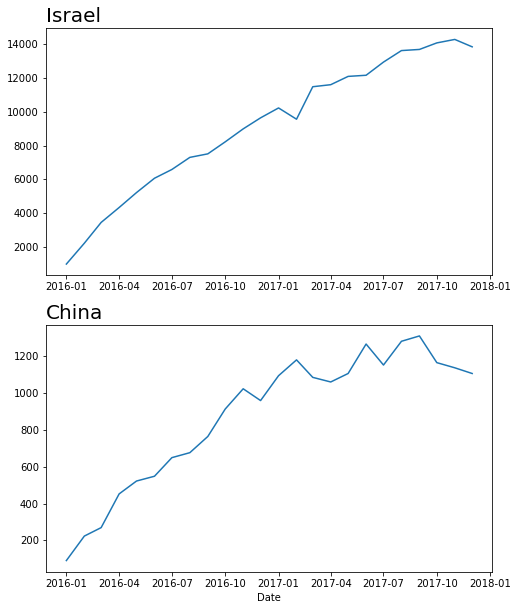

In [134]:
fig, axs = plt.subplots(2, 1, figsize=(8, 10))

axs[0].plot(israel_robot_count.index.to_timestamp(), israel_robot_count)
axs[0].set_title('Israel', loc='left', size=20)

axs[1].plot(china_robot_count.index.to_timestamp(), china_robot_count)
axs[1].set_title('China', loc='left', size=20)

plt.xlabel('Date');